In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
from configs.seq_fd_gru import hparams
hparams = hparams()
print(hparams)

[('batch_size', 800), ('datagen', 'prodn'), ('in_seq_len', 168), ('input_channels', 1), ('input_dim', 5), ('lambd', 1e-06), ('learning_rate', 0.001), ('logs_path', '/tmp/tensorflow_logs'), ('lr_decay', 0.99), ('neurons_unit', 32), ('norm_epsilon', 1e-12), ('num_layers', 1), ('out_seq_len', 24), ('output_channels', 1), ('output_dim', 1), ('test_split', 0.1), ('train_split', 0.8), ('val_split', 0.1)]


In [92]:
hparams=tf.contrib.training.HParams(
        batch_size=800,
        in_seq_len=168,
        input_dim=5,
        input_channels=1,
        out_seq_len=24,
        output_dim=1,
        output_channels=1,
        num_layers=1,
        neurons_unit=32,
        learning_rate = 10 ** -2.5,
        lr_decay = 0.99,
        lambd = 1e-6,
        train_split = 0.8,
        val_split = 0.1,
        test_split = 0.1,
        norm_epsilon = 1e-12,
        datagen = 'prodn',
        logs_path = '/tmp/tensorflow_logs')

In [7]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)
inp, target, mask, x_max = next(iter(dataset))

In [13]:
tf.keras.layers.Conv1D(1, 2, padding='valid', activation='linear', use_bias=False,
                                         kernel_initializer = tf.constant_initializer([-1,1]))

[]

In [18]:
class pAttention(tf.keras.Model):
    def __init__(self):
        super(pAttention, self).__init__()
        self.W1 = tf.Variable(2., name='W_separation')
        self.W2 = tf.Variable(1., name='W_scale')

    def cov(self, x):

        n_dim  = tf.cast(tf.shape(x)[1], tf.float32) - 1
        mu_x   = x - tf.reduce_mean(x, axis=1, keep_dims=True)
        cov_xx = tf.matmul(mu_x, mu_x, transpose_a=True) / n_dim
        
        return cov_xx
    
    def call(self, x, hidden):
        cov = self.cov(x)
        cov = tf.reduce_sum(cov, axis=1)
        cov = cov / tf.reduce_max(cov, axis=1, keep_dims=True)

        score   = tf.exp(self.W1) * cov
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=1)
        
        outputs = self.W2 * tf.reduce_mean(weights * tf.squeeze(hidden), axis=-1, keepdims=True) 
        
        return outputs

In [93]:
class MiniConvRNN(tf.keras.Model):
    def __init__(self, input_dim, output_dim, in_seq_len, out_seq_len, neurons_unit, batch_size, name=None):
        super(MiniConvRNN, self).__init__()

        self.input_dim    = input_dim
        self.output_dim   = output_dim
        self.in_seq_len   = in_seq_len
        self.out_seq_len  = out_seq_len
        self.neurons_unit = neurons_unit
        self.batch_size   = batch_size
        
        self.cat = tf.keras.layers.Concatenate(axis=-1)
        
        self.conv1_2x1  = tf.keras.layers.Conv1D(1, 2, padding='valid', activation='linear', use_bias=False,
                                                 kernel_initializer = tf.constant_initializer([-1,1]),
                                                 name='conv1_first_diff_2')
        #self.conv1_3x1  = tf.keras.layers.Conv1D(1, 3, padding='valid', activation='linear', use_bias=False,
        #                                         kernel_initializer = tf.constant_initializer([-1,0,1]),
        #                                         name='conv1_first_diff_3')


        self.conv1_f    = tf.keras.layers.Conv2D(1, (1,2), padding='valid', activation='linear', use_bias=False,
                                                 kernel_initializer = tf.constant_initializer([0.75,0.25]))
        
        self.conv1_3x1  = tf.keras.layers.Conv1D(1, 24, padding='valid', activation='linear', use_bias=False,
                    kernel_initializer = tf.constant_initializer(np.zeros(24)),
                    name='conv1_first_diff_24')
        #self.conv2_2x1  = tf.keras.layers.Conv1D(2, 2, padding='valid', activation='tanh')
        #self.conv2_36x1 = tf.keras.layers.Conv2D(1, (1,2), padding='valid', activation='tanh')

        self.attn = pAttention()
        
    def reshape_deep(self, x):
        x = tf.reshape(x, [self.batch_size, self.input_dim, self.out_seq_len, -1])
        return tf.transpose(x, [0,2,1,3])
        
    def reshape_wide(self, x):
        x = tf.transpose(x, [0,2,1,3])
        return tf.reshape(x, [self.batch_size, self.input_dim * self.out_seq_len, -1])
    
    def encode(self, x):
        pos = self.out_seq_len * self.input_dim
        
        conv1_2x1 = self.conv1_2x1(x)
        conv1_3x1 = self.conv1_3x1(x)
        
        conv1 = self.cat([conv1_2x1[:,-pos:], conv1_3x1[:,-pos:]])
        conv1 = self.conv1_f(tf.expand_dims(conv1,-1))
        conv1 = tf.squeeze(conv1)

        return self.reshape_deep(conv1)
        
    def call(self, inp, mask):
        
        enc_out = self.encode(inp)
        
        pos = self.out_seq_len * self.input_dim
        context = self.reshape_deep(inp[:,-pos:])
        context = self.attn(tf.squeeze(context), enc_out)
        context = tf.cumsum(context, axis=1)
        
        x = inp[:,-1:]

        return (x + context) * mask
        """output = x + tf.squeeze(tf.reduce_sum(enc_out,2))
        
        return tf.expand_dims(output, -1)
        
        pos = self.out_seq_len * self.input_dim
        context = self.reshape_deep(inp[:,-pos:])
        context = self.attn(tf.squeeze(context), enc_out)
        
        
        outputs = context + x
        
        return tf.expand_dims(outputs,-1)"""

In [94]:
inp, target, mask, x_max = next(iter(dataset))
model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
               hparams.neurons_unit, hparams.batch_size)
conv1 = model.encode(inp)
#model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32),
#                             np.array([0.], dtype=np.float32)])
model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32)])
fcast = model.call(inp, mask)
conv1 = model.encode(inp)
cox = tf.cumsum(tf.squeeze(conv1))
fcast.shape, conv1.shape, cox.shape

(TensorShape([Dimension(800), Dimension(24), Dimension(1)]),
 TensorShape([Dimension(800), Dimension(24), Dimension(5), Dimension(1)]),
 TensorShape([Dimension(800), Dimension(24), Dimension(5)]))

In [95]:
atn  = pAttention().cov(tf.squeeze(model.reshape_deep(inp[:,-pos:])))
#atn_ = tf.reduce_sum(atn, axis=1)
atn_ = np.sum((atn / np.max(atn, axis=(1,2), keepdims=True)), axis=1)
act  = tf.nn.softmax(np.exp(0.5) * atn_, axis=1)
atn[160], atn_[160], act[160] * 100

(<tf.Tensor: id=3149329, shape=(5, 5), dtype=float32, numpy=
 array([[ 3.3116464e-06,  3.2447874e-06,  3.1867321e-06,  3.6882936e-06,
         -2.7621372e-05],
        [ 3.2447874e-06,  3.2776563e-06,  3.2796740e-06,  3.6826561e-06,
         -3.0595216e-05],
        [ 3.1867321e-06,  3.2796740e-06,  3.4063642e-06,  3.5818498e-06,
         -2.9145980e-05],
        [ 3.6882936e-06,  3.6826561e-06,  3.5818498e-06,  4.5305915e-06,
         -4.2322961e-05],
        [-2.7621370e-05, -3.0595220e-05, -2.9145978e-05, -4.2322958e-05,
          9.9608628e-04]], dtype=float32)>,
 array([-0.01424566, -0.01717767, -0.01575301, -0.02694502,  0.8698049 ],
       dtype=float32),
 <tf.Tensor: id=3149334, shape=(5,), dtype=float32, numpy=
 array([12.095685, 12.037356, 12.065661, 11.845062, 51.956238],
       dtype=float32)>)

[<tf.Variable 'conv1_first_diff_2/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
array([[[-1.]],

       [[ 1.]]], dtype=float32)>]


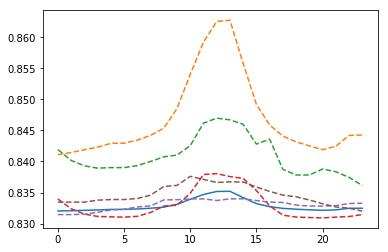

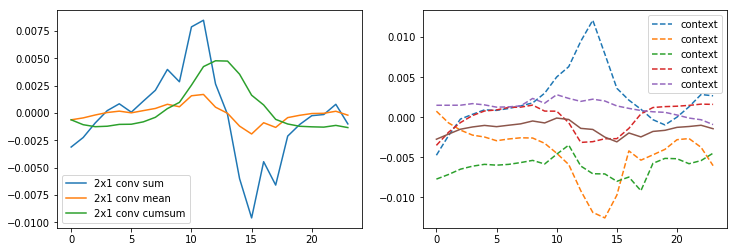

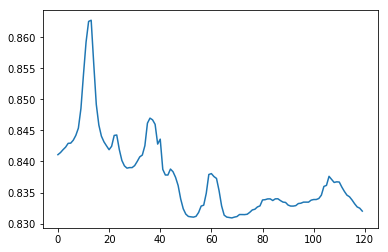

In [96]:
n = 24
pos = hparams.out_seq_len * hparams.input_dim
print(model.conv1_2x1.variables)

plt.plot(np.array(fcast[n]))
plt.plot(np.array(model.reshape_deep(inp[:,-pos:]))[n,:,:,0], '--')
plt.show()

plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
ax.plot(np.array(conv1[n]).sum(axis=(1)), label='2x1 conv sum')
ax.plot(np.array(conv1[n]).mean(axis=(1)), label='2x1 conv mean')
ax.plot(np.cumsum(conv1[n], axis=0).mean(axis=(1)), label='2x1 conv cumsum')
plt.legend()
ax = plt.subplot(1,2,2)
ax.plot(np.array(cox[n]), '--', label='context')
ax.plot(np.array(cox[n]).mean(axis=1))
plt.legend()
plt.show()

plt.plot(np.array(inp[n,-120:]))
plt.show()

## Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

Loss 0.0216 Accuracy 0.0192 Time 17.1488


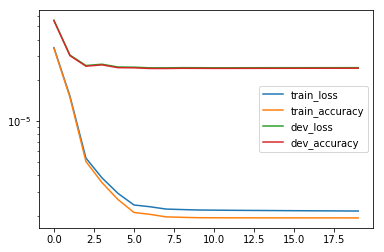

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate_18 (Concatenate) multiple                  0         
_________________________________________________________________
conv1_first_diff_2 (Conv1D)  multiple                  2         
_________________________________________________________________
conv2d_18 (Conv2D)           multiple                  2         
_________________________________________________________________
conv1_first_diff_24 (Conv1D) multiple                  24        
_________________________________________________________________
p_attention_24 (pAttention)  multiple                  2         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [97]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=20, verbose=False, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 10000, accuracy * 10000, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

#trainer.save_model(model, optimizer, dataset_val, hparams, 'fd_mini' + get_fields.replace(' ', '_'), stats=stats)
model.summary()

In [105]:
model.variables, optimizer._lr

([<tf.Variable 'mini_conv_rnn_18/conv1_first_diff_2/kernel:0' shape=(2, 1, 1) dtype=float32, numpy=
  array([[[-1.0015599]],
  
         [[ 0.9977404]]], dtype=float32)>,
  <tf.Variable 'mini_conv_rnn_18/conv2d_18/kernel:0' shape=(1, 2, 1, 1) dtype=float32, numpy=
  array([[[[0.6756371 ]],
  
          [[0.19058865]]]], dtype=float32)>,
  <tf.Variable 'mini_conv_rnn_18/conv1_first_diff_24/kernel:0' shape=(24, 1, 1) dtype=float32, numpy=
  array([[[ 0.00238743]],
  
         [[ 0.00265838]],
  
         [[ 0.00287391]],
  
         [[ 0.00301311]],
  
         [[ 0.00306281]],
  
         [[ 0.00301751]],
  
         [[ 0.00287558]],
  
         [[ 0.00263844]],
  
         [[ 0.00231205]],
  
         [[ 0.00190764]],
  
         [[ 0.00143964]],
  
         [[ 0.00092847]],
  
         [[ 0.00039925]],
  
         [[-0.00011817]],
  
         [[-0.00059822]],
  
         [[-0.00102176]],
  
         [[-0.00137162]],
  
         [[-0.00163594]],
  
         [[-0.00181152]],
  
        

In [ ]:
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=2000, verbose=False, dev_dataset=dataset_val)
print(np.array(loss) * 10000, np.array(accuracy) * 10000, run_time)
model.variables, optimizer._lr

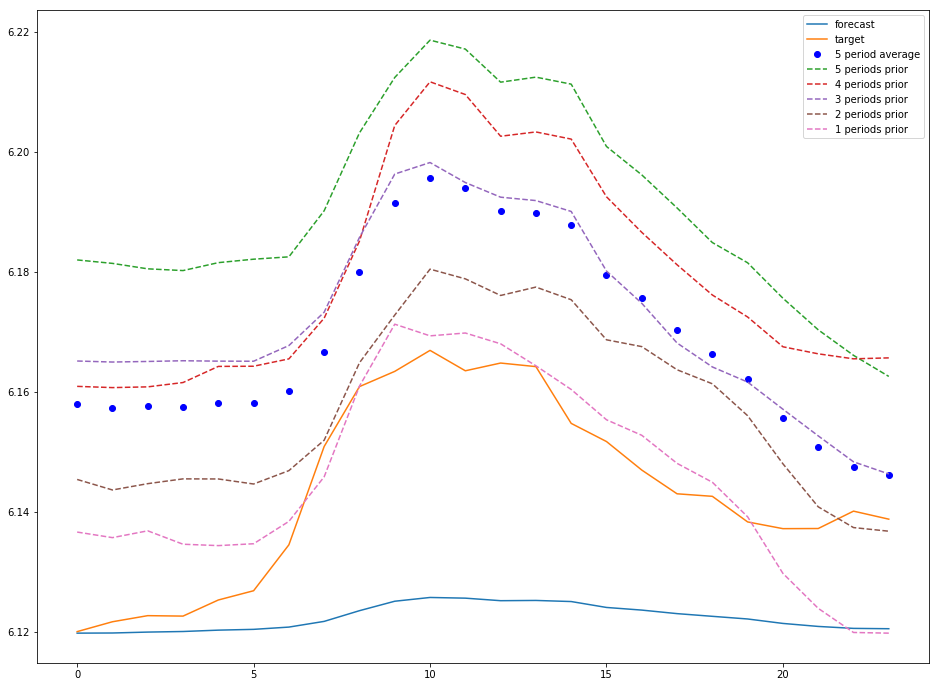

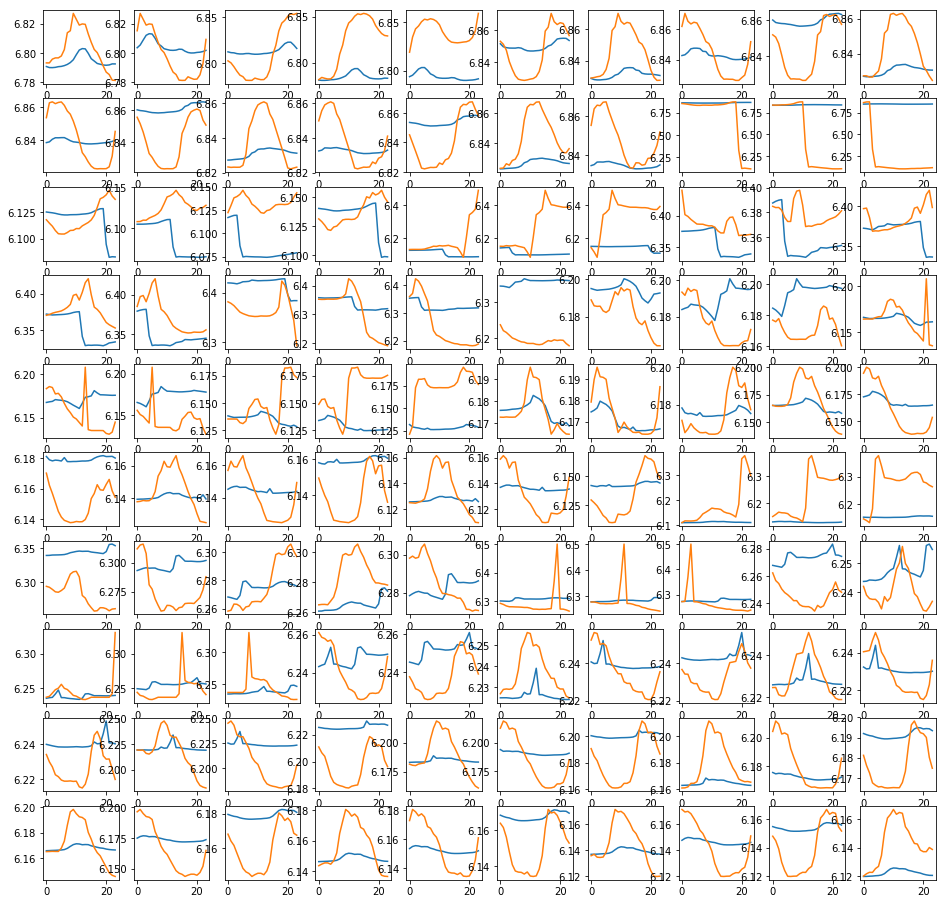

In [104]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = -8

# Create forecast and rescale data
_, (inp, target, mask, x_max) = enumerate(dataset).__next__()
x_max = tf.expand_dims(x_max,-1)
forecast = model(inp, mask)
forecast *= x_max
target   *= x_max
inp      *= x_max
inp = tf.reshape(inp[:,-120:], [hparams.batch_size, hparams.input_dim, hparams.out_seq_len, -1])
inp = tf.transpose(inp, [0,2,1,3])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

## Test Hyperparameters

In [152]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

inp, target, mask, x_max = next(iter(dataset))

#for lr in np.random.uniform(-8, -1, 10):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model = MiniConvRNN(hparams.input_dim, hparams.output_dim, hparams.in_seq_len, hparams.out_seq_len,
                       hparams.neurons_unit, hparams.batch_size)
    conv1 = model.encode(inp)
    model.conv1_2x1.set_weights([np.array([[[-1.0]], [[ 1.0]]], dtype=np.float32),
                             np.array([0.], dtype=np.float32)])
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        trainer.train_model(model, optimizer, dataset, hparams, epochs = 50, verbose=False)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*10000, accuracy * 10000, run_time))
    
    models.append(model)
    stats.append(stat)

Learning Rate -4.0000 Loss 0.0269 Accuracy 0.0269 Time 12.4
Learning Rate -3.5000 Loss 0.0268 Accuracy 0.0268 Time 12.3
Learning Rate -3.0000 Loss 0.0263 Accuracy 0.0263 Time 12.5
Learning Rate -2.5000 Loss 0.0264 Accuracy 0.0264 Time 13.4
Learning Rate -2.0000 Loss 0.0263 Accuracy 0.0263 Time 13.1
Learning Rate -1.5000 Loss 0.0253 Accuracy 0.0253 Time 13.0
Learning Rate -1.0000 Loss 0.0224 Accuracy 0.0224 Time 12.5
Learning Rate -0.5000 Loss 0.0196 Accuracy 0.0196 Time 14.4
